In [37]:
import io
import os
import base64
import openai
from openai import OpenAI
from pydantic import BaseModel
from PIL import Image, ImageDraw

# Please provide your openai API below 
API_KEY = 

def encode_image(pil_image):
    if pil_image.mode == "RGBA":
        pil_image = pil_image.convert("RGB")
    buffer = io.BytesIO()
    pil_image.save(buffer, format="JPEG")
    return base64.b64encode(buffer.getvalue()).decode('utf-8')

def draw_point_bbox(image_path, point=None, bbox=None, radius=5, line=3, vis=False):
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    width, height = image.size
    
    if point is not None:
        x, y = point[0] * width, point[1] * height
        draw.ellipse((x - radius, y - radius, x + radius, y + radius), fill='blue', outline='blue')
    if bbox is not None:
        x1, y1, x2, y2 = bbox[0] * width, bbox[1] * height, bbox[2] * width, bbox[3] * height
        draw.rectangle([x1, y1, x2, y2], outline='red', width=line)
    if vis:
        display(image)
    return image

def get_description(image_pil, label):
    base64_image = encode_image(image_pil)
    
    class DescriptionList(BaseModel):
        appearance: str
        spatial: str
        situational: str
    
    client = OpenAI(
        api_key=API_KEY,
    )
    completion = client.beta.chat.completions.parse(
        model="gpt-4o",
        messages=[{"role": "user","content": [
                {"type": "text",
                 "text": 
                 f"""
                    You will receive a screenshot with a red bounding box surrounding the target element, along with the target element’s name. 
                    Analyze the screenshot and provide concise descriptive responses for each of the following dimensions.
                    
                    1. **appearance**: Describe the target element’s color, shape, ocr and other visual characteristics.
                       - Example: "A rectangular chat card with a blue background to 'Ash.'"
                    
                    2. **spatial**: Describe the target element’s position based on the contextual spatial relationship.
                       - Example: "The element that positioned above the Clara."
                    
                    3. **situational**: Create an intent-oriented query related to the target element, considering how a user might interact with it.
                       - Example: "Send a message to Ash."
                    
                    Please follow these guidelines:
                    - Do not confuse the red bounding box with the element itself.
                    - Provide responses as concise sentences (15 words or fewer).
                    - For each types, make the description specific enough to distinguish it from other elements.
                    - If a dimension does not apply, respond with "None."
                    - Structure your response in JSON format as shown below:
                    
                    ```json
                    {{
                      "appearance": "A rectangular chat card with a blue background with letter 'A'",
                      "spatial": "The element that positioned above the Clara.",
                      "situational": "Send a message to Ash."
                    }}
                """
                },
                {"type": "image_url",
                 "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}},
                {"type": "text",
                 "text": f"The target element is {label}."}
                ],
            }],
        response_format=DescriptionList
        )
    content = completion.choices[0].message.content
    return content

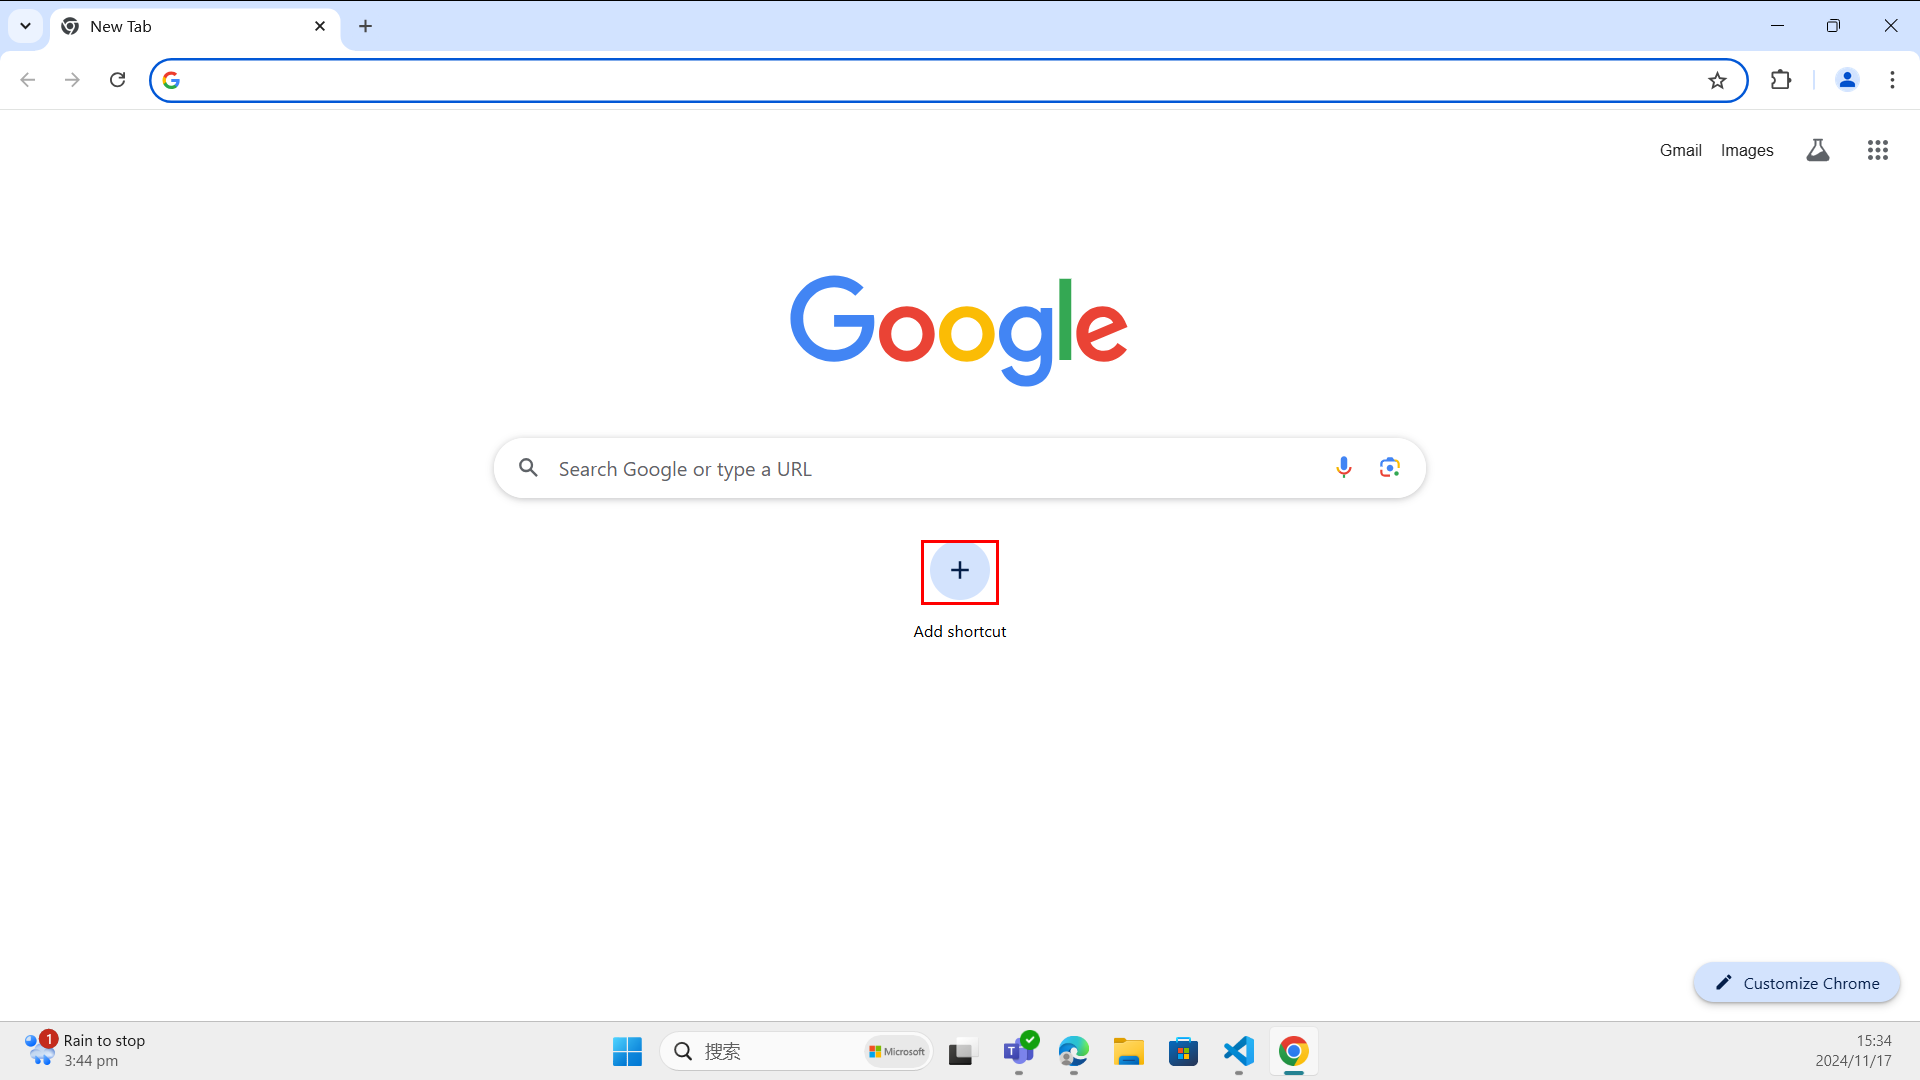

GPT4o Recaption result:


'{"appearance":"A blue circular button with a white plus sign.","spatial":"Centered below the Google search bar.","situational":"Add a new shortcut."}'

In [39]:
img_url = 'examples/0730d43001da36204b8cb9495b61308.png'
box = [0.48, 0.5, 0.52, 0.56]
org_name = 'Add item'

img_vis = draw_point_bbox(img_url, bbox=box, vis=True)
print("GPT4o Recaption result:")
get_description(img_vis, org_name)